# Attribution: Observations

In this notebook we are going to calculate the probability ratio for our event.
Each dataset is handled sequentially, starting with GridClim (or another reference dataset).
For each dataset it is possible to first select a sub-period of the year.
After this the index is calculated.
After some evaluation the spatially averaged index series is used to compute the probability ratio, and its confidence interval.
The heavy lifting is done in `attribution.bootstrap.calc_prob_ratio_ci`.

In the case that the event is defined/evaluated by multiple indices this notebook could be run multiple times with different values for `index_name` and `variable`.
The filename of any data that is saved to disk uses the `index_name` variable, so no unintentional overwrites should occur.

In [1]:
import glob
import os
from functools import partial
from textwrap import wrap

import attribution.funcs
import attribution.utils
import attribution.validation
import cartopy.crs as ccrs
import cftime
import iris
import iris.plot as iplt
import nc_time_axis
import numpy as np
import proplot as pplt
import scipy.stats as scstats
import seaborn as sns
from attribution.config import init_config
from climix.metadata import load_metadata
from dask.distributed import Client

/home/sm_erhol/dev/attribution/attribution/bootstrap.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# The bootstrapping works best without multithreading.
client = Client(processes=True, threads_per_worker=1)

We load in the the configuration from the project `.yml`.

In [3]:
CFG = init_config()

In [4]:
# Uncomment to have a look at the CFG
# CFG

## Load the data
Let's load the GridClim data we prepared earlier.

In [4]:
# We are investigating multiple variables, have to select one.
variables = CFG["variable"]

In [5]:
# Which variable will we use?
variable = variables[0]
print(variable)

tasmax


## Index definition
We will define our event using a climate index.
The index can be loaded from the `config.yml` through the `CFG` variable.

In [6]:
# This can hold multiple index names.
index_names = CFG["index_name"]

Select one of the indices.
Simply change the 0 below and run the notebook to perform the calculation for a different index.
Remember that some indices require a different variable.
In that case the `variable` variable also has to be changed.

In [7]:
index_name = index_names[0]
print(index_name)

txge25


In [8]:
index_catalog, _ = load_metadata()
index = index_catalog.prepare_indices([index_name])[0]

## GridClim

We start the analysis with the GridClim dataset.
Where can we find it?

In [9]:
file = glob.glob(CFG["paths"]["project_folder"] + f"/{variable}*GridClim*.nc")

In [10]:
# GridClim
iris.FUTURE.datum_support = True
cube = iris.load_cube(file)

In [11]:
# cube

### Selecting summer data

We begin by selecting summer data for the time period.
In this case, this means we want data from May until August.

In [12]:
# If we want to select the last 30 years.
# constraint = iris.Constraint(time=lambda cell: cell.point.year > 2018 - 30)
# cube = cube.extract(constraint)

In [13]:
mjja_cube = attribution.utils.select_season(cube, "mjja", "summer")

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

Here we calculate the spatial average of the index cube.

In [14]:
mjja_cube_av = attribution.utils.compute_spatial_average(mjja_cube)

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

In [15]:
# mjja_cube

In [16]:
# iplt.contourf(mjja_cube[500, :, :]);

### Compute index
We then compute the index using the summer data.

In [17]:
index_cube = attribution.utils.compute_index(mjja_cube, index, client)

In [18]:
index_cube_av = attribution.utils.compute_index(mjja_cube_av, index, client)

In [19]:
# index_cube

In [19]:
index_cube_av.shape

(30,)

#### Threshold definition
Now we can get the threshold of the event.
In this case it means the index value of the year of 2018, which is the last entry in the series.

In [20]:
# Summer 2018
threshold = index_cube_av[-1].data

In [21]:
threshold

array(47., dtype=float32)

#### Presentation time series plot

Below is a plot of the index series.

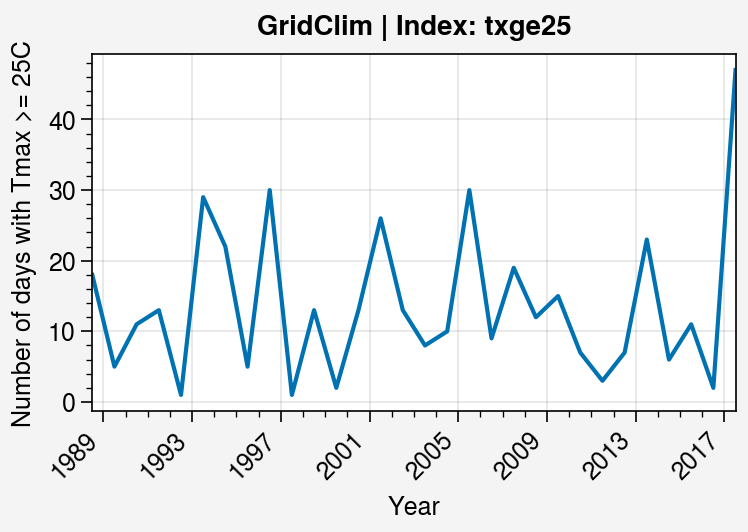

In [22]:
# Style context manager.
fig, ax = pplt.subplots(figwidth="9.5cm", aspect=1.8)
# Plot the data
iplt.plot(
    index_cube_av,
    axes=ax,
)
ax.format(
    ylabel="\n".join(wrap(f"{index_cube_av.long_name}", 35)),
    xlabel="Year",
    suptitle=f"GridClim | Index: {index_name}",  # | Event: Summer 2018",
    xlocator=("year", 4),
    xrotation=45,
)

In [21]:
# Save
fig.save(
    f"../../plots/gc_{index_name}_timeseries.pdf",
    facecolor="none"
)

### Fitting an extreme value distribution to the index

The next step is to fit an extreme value distribution to index series.
Below we have defined a dictionary holding a few common distributions.

In [23]:
# Some distributions describing extremes.
dists = {
    "genextreme": scstats.genextreme,
    "gamma": scstats.gamma,
    "genpareto": scstats.genpareto,
    "gengamma": scstats.gengamma,
    "gumbel_l": scstats.gumbel_l,
    "gumbel_r": scstats.gumbel_r,
}

Before we do the bootstrap, we want to check the goodness of fit for the distribution and the data.
For this we use a Kolmogorov-Smirnof test (KS-test).
The 0-hypothesis is that the distributions are the different, hence we are looking for a high p-value.
This is very convenient with function `inspect_distributions`.

In [24]:
cube_data = index_cube_av.data

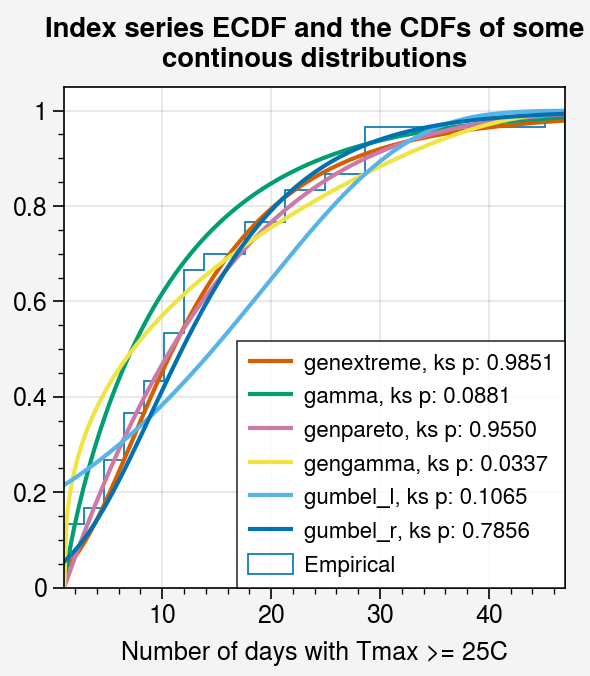

In [25]:
fig, ax = pplt.subplots(figwidth="7.5cm", refaspect=1)
_ = attribution.validation.inspect_distributions(cube_data, dists, ax=ax)
# ax.set_ylabel("Density")
ax.legend(ncols=1, fontsize=8)
ax.format(
    suptitle="Index series ECDF and the CDFs of some\ncontinous distributions",
    xlabel=f"{index_cube_av.long_name}",
)
fig.save(
    f"../../plots/{index_name}_ecdf.pdf",
    facecolor="none"
)

Most of the distributions represents the data fairly well, with the exception of the `gumbel_l` and `genpareto` distributions 

<div class="alert alert-info"> <b>Note </b>This will vary depending on index and data used in running the notebook.</div>

Later we will need the quantile of the threshold to compute the "relative" thresholds for other datasets.
This is because different datasets can have different biases, which means that the absolute threshold for this dataset doesn't necessarily translate to other datasets.

Here we first select best fitting distribution and then compute the quantile.
We save the quantile so we can load it lates.

In [26]:
# Some distributions describing extremes.
dists = {
    # "genextreme": scstats.genextreme,
    # "gamma": scstats.gamma,
    # "genpareto": scstats.genpareto,
    # "gengamma": scstats.gengamma,
    # "gumbel_l": scstats.gumbel_l,
    "gumbel_r": scstats.gumbel_r,
}

In [27]:
best_dist = attribution.validation.select_distribution(cube_data, dists)
print(best_dist)
# Fit the distribution.
fit = best_dist.fit(cube_data)
# Get the quantile of the survival function.
threshold_quantile = best_dist.sf(threshold, *fit)

# Save it for later
np.save(
    os.path.join(CFG["paths"]["project_folder"], f"etc/{index_name}_gc_threshold_q"),
    threshold_quantile,
)

#### Presentation distribution plot

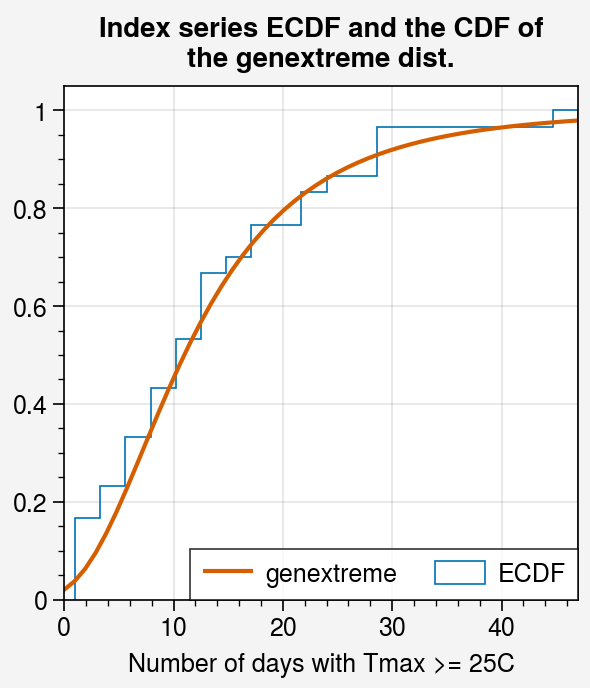

In [29]:
fig, ax = pplt.subplots(figwidth="7.5cm", refaspect=1)
dist = best_dist
fit = dist.fit(index_cube_av.data.compressed())
ax.hist(
    index_cube_av.data.compressed(),
    bins=20,
    cumulative=True,
    density=True,
    histtype="step",
    label="ECDF",
)
x = np.linspace(0, index_cube_av.data.compressed().max())
ax.plot(x, dist.cdf(x, *fit), label=best_dist.name)
# dist = dists["genextreme"]
fit = dist.fit(index_cube_av.data.compressed())
ax.legend(loc="lower right")
ax.format(
    xlabel=f"{index_cube_av.long_name}",
    suptitle=f"Index series ECDF and the CDF of\nthe {best_dist.name} dist.",
)

### Regression to GMST
The above distribution will be shifted/scaled using its regression coefficient to GMST.

First we load the GISTEMP data from NASA.

In [28]:
# This gives us the smoothed gmst data for the timespan
# covered by the cube.
gmst_data = attribution.utils.get_gmst(index_cube)

We then compute the regression between the index series and GMST in each grid point.

In [29]:
coefs, pvalues = attribution.utils.compute_cube_regression(
    index_cube, gmst_data, broadcast_coef=False
)

  0%|          | 0/44 [00:00<?, ?it/s]

And plotting the regression over the area is easy

In [30]:
from importlib import reload

In [31]:
reload(attribution.plotting)

<module 'attribution.plotting' from '/home/sm_erhol/dev/attribution/attribution/plotting.py'>

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


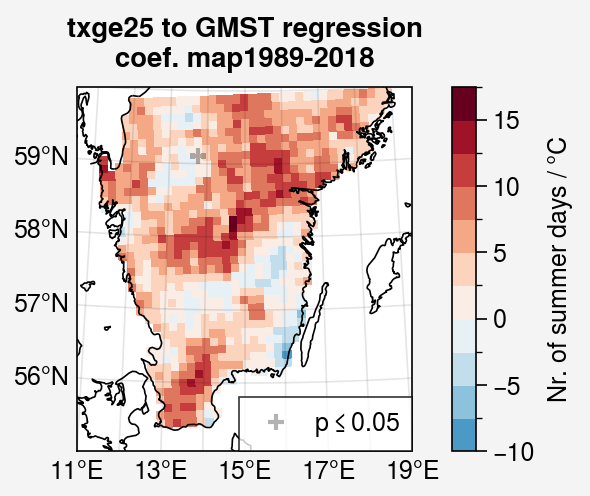

In [32]:
fig, ax = pplt.subplots(figwidth="7.5cm", projection=ccrs.epsg(3006))
cm = attribution.plotting.plot_regression_map(
    index_cube,
    index_name=index_name,
    reg_coefs=coefs,
    pvalues=pvalues,
    p_lim=0.05,
    ax=ax[0],
)
ax.legend(loc="lower right")
ax.colorbar(cm, title="Nr. of summer days / $\degree$C", width="0.3cm")
ax.set_extent((11, 19, 55, 60))
t0 = index_cube.coord("time").cell(0).point.strftime("%Y")
t1 = index_cube.coord("time").cell(-1).point.strftime("%Y")
ax.format(
    coast=True,
    borders=True,
    reso="hi",
    title="",
    suptitle=f"{index_name} to GMST regression\ncoef. map{t0}-{t1}",
    latlabels="l",
    lonlabels="b",
)

In [33]:
fig.save(f"../../plots/{index_name}_regression_map.pdf", facecolor="none")

For later we are also going to need the regression of the spatially averaged index.
Here we also get the confidence interval of the regression coefficient.
This is used later to evaluate model ensemble members.

In [34]:
coefs_av, pvalues_av, coefs_ci = attribution.utils.compute_cube_regression(
    index_cube_av, gmst_data, broadcast_coef=False
)

In [35]:
pvalues_av

0.686176184169923

In [36]:
coefs_av

4.605819965733231

In [37]:
coefs_ci

array([[ -1.95990905,  24.36873548],
       [-18.50252542,  27.71416535]])

### Calculating the probability ratios

Now we are ready to calculate the probability ratios for the event, including confidence intervals.
The probability ratios are calculated from the fraction of the probability for the event under the current climate ($p_1$) to the probability under the *counterfactual climate* ($p_0$)
$$
\frac{p_1}{p_0},
$$
where we get the counterfactual climate is represented by the shifted distribution.

To get the confidence intervals of the probability ratio the method employs a bootstrap procedure.
This entails creating `n_resamples` random realisations of the original dataset and then performing the steps done above: regression to GMST, shifting and finally calculating the probability ratio, for each realisation. 

Quick look at the index_cube data.

Here we calculate the probability ratio confidence interval (including the median).
In the first instance we will only shift/scale realisations which exhibits a significant regression.
This is controlled by the `p_lim=0.05` kwarg.

#### Detrended CI
We also calculate a confidence interval like above, but with de-trended data.
The idea is to move the entire index series to a climate representing the last year of the dataset.

We do this by again using the regression to GMST to shift the values.

In [38]:
# Since we want to shift every year to 2018 using the regression,
# we set 2018 to zero change.
gmst_diff = gmst_data[-1] - gmst_data
index_detrend = index_cube_av.data + coefs_av * gmst_diff.T

In [39]:
rng = np.random.default_rng()

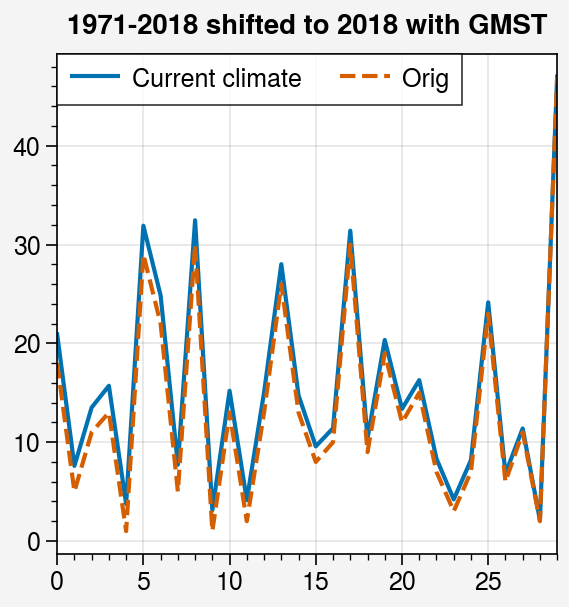

In [40]:
fig, ax = pplt.subplots()
ax.plot(index_detrend.compressed(), label="Current climate")
ax.plot(index_cube_av.data.compressed(), label="Orig", ls="--")
ax.legend()
ax.format(suptitle="1971-2018 shifted to 2018 with GMST")

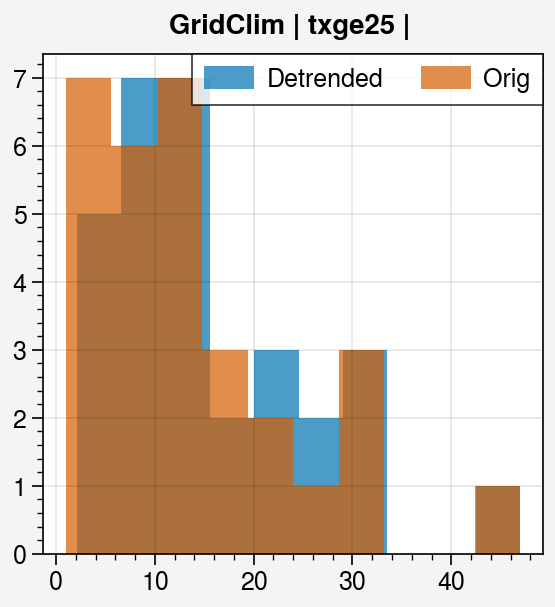

In [41]:
fig, ax = pplt.subplots()
ax.hist(index_detrend.compressed(), label="Detrended", alpha=0.7)
ax.hist(index_cube_av.data.compressed(), label="Orig", alpha=0.7)
ax.legend()
ax.format(suptitle=f"GridClim | {index_name} | ")

In [42]:
# Should be very close to 0.
coefs_detrend, _, = attribution.utils.compute_cube_regression(
    index_detrend, gmst_data, broadcast_coef=False
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
coefs_detrend

array([7.10542736e-15])

In [44]:
# Create a cube with de-trended data.
index_cube_av_detrend = index_cube_av.copy()
index_cube_av_detrend.data = index_detrend.squeeze()

We can inspect the distribution for this data as well.

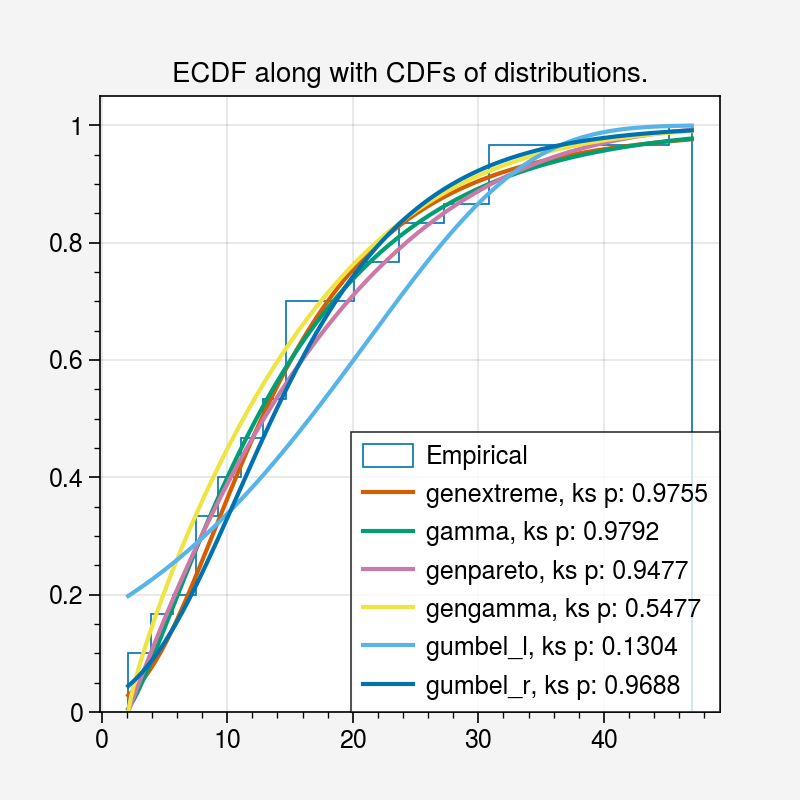

In [46]:
_ = attribution.validation.inspect_distributions(index_cube_av_detrend.data, dists)

Similar to the data which hasn't been de-trended we need to calculate the threshold quantile and save for later use.

In [68]:
# Some distributions describing extremes.
dists = {
    # "genextreme": scstats.genextreme,
    # "gamma": scstats.gamma,
    # "genpareto": scstats.genpareto,
    # "gengamma": scstats.gengamma,
    # "gumbel_l": scstats.gumbel_l,
    "gumbel_r": scstats.gumbel_r,
}

In [69]:
best_dist = attribution.validation.select_distribution(
    index_cube_av_detrend.data, dists
)
print(best_dist)
# Fit the distribution.
fit = best_dist.fit(index_cube_av_detrend.data)
# Get the quantile of the survival function.
threshold_quantile = best_dist.sf(threshold, *fit)
# Save it for later
np.save(
    os.path.join(
        CFG["paths"]["project_folder"], f"etc/{index_name}_gc_threshold_q_detrend"
    ),
    threshold_quantile,
)

In [70]:
threshold_quantile

0.008611391914964801

Then we get the probability ratio (and CI).
For this we don't have to pass the de-trended data but simply set `detrend=True` and the data is de-trended before the bootstrap is initiated.
Using the de-trended data, the regression will be held constant for all realisations and `p_lim` has no effect.

In [71]:
reload(attribution.bootstrap)

<module 'attribution.bootstrap' from '/home/sm_erhol/dev/attribution/attribution/bootstrap.py'>

In [72]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
# Note that we're not passing the detrended cube here. Cube is de-trended by the detredn kwarg.
prob_ratio_ci, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=1.0,
    detrend=True,
    dists=dists,
    client=client,
)

Submitting resampling tasks to client
Time to compute: 00:00:01


In [73]:
prob_ratio_ci

array([1.78513531, 1.94916373, 2.08482868, 2.26456714, 2.60932631])

In [74]:
1 - (1 / prob_ratio_ci)

array([0.43981837, 0.48695947, 0.52034428, 0.55841451, 0.61675932])

Save the CI.

In [75]:
np.save(
    os.path.join(
        CFG["paths"]["project_folder"], f"etc/{index_name}-ann_pbr_gridclim_detrend"
    ),
    prob_ratio_ci,
)

Visualisation of the probability ratios will be done in a later notebook, when all the datasets have been analysed.
For the following datasets the explanations won't be as thorough.

#### Presentation shifted distribution plot
Below is an illustration of the original distribution and a distribution that has been shifted "back in time" using the regression coefficient to GMST.
The shift is done using the `shift_dist_params` function.

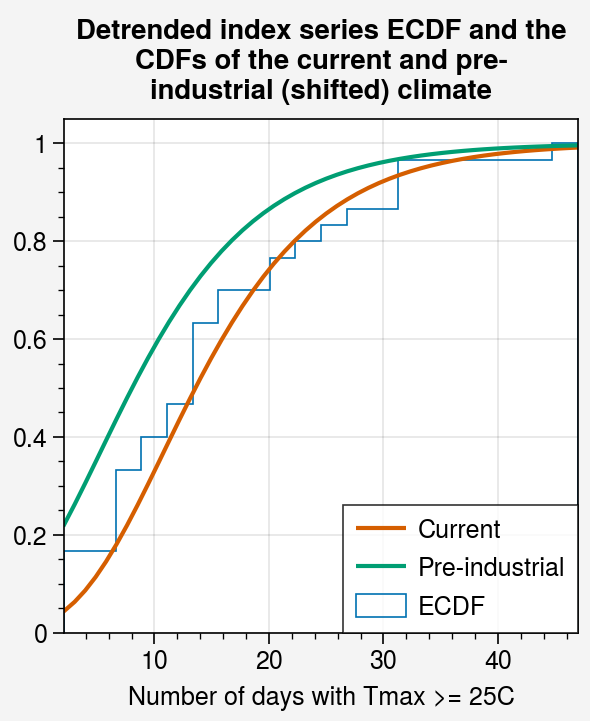

In [76]:
fig, ax = pplt.subplots(figwidth="7.5cm")
dist = best_dist
fit = dist.fit(index_cube_av_detrend.data.compressed())
ax.hist(
    index_cube_av_detrend.data.compressed(),
    bins=20,
    cumulative=True,
    density=True,
    histtype="step",
    label="ECDF",
)
x = np.linspace(index_cube_av_detrend.data.min(), index_cube_av.data.max())
ax.plot(x, dist.cdf(x, *fit), label="Current")
# loc0 = fit[1] + coefs_av * -1.2
# fit0 = (fit[0], loc0, fit[2])
fit0 = attribution.funcs.shift_dist_params(-1.2, fit, coefs_av)
ax.plot(x, dist.cdf(x, *fit0), label="Pre-industrial")
ax.legend(ncols=1)
title = "\n".join(
    wrap(
        "Detrended index series ECDF and the CDFs\nof the current and\npre-industrial (shifted) climate ",
        35,
    )
)
ax.format(
    xlabel="\n".join(wrap(f"{index_cube.long_name}", 35)),
    suptitle=title,
)
fig.save(f"../../plots/{index_name}_ecdf_shifted.pdf", facecolor="none")

In [73]:
1 - (dist.sf(threshold, *fit0) / dist.sf(threshold, *fit))

0.40586034462571174

#### Legacy

In [123]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
prob_ratio_ci, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    dists=dists,
    p_lim=0.05,
    client=client,
)

Submitting resampling tasks to client
Time to compute: 00:00:39


In [124]:
prob_ratio_ci

array([0.02409995, 1.        , 1.        , 1.        , 1.        ])

Here all realisations, no matter regression significance, are shifted/scaled.

In [60]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
prob_ratio_ci_2, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=1.0,
    dists=dists,
    client=client,
)

Submitting resampling tasks to client
Time to compute: 00:00:39


In [61]:
prob_ratio_ci_2

array([2.59429712e-02, 1.07598862e-01, 5.52651145e-01, 1.86098754e+00,
       3.90883933e+01])

In [130]:
prob_ratio_ci = np.concatenate(
    [prob_ratio_ci_2[np.newaxis, ...], prob_ratio_ci[np.newaxis, ...]], axis=0
)

Save the CI for later use.

In [131]:
np.save(
    os.path.join(CFG["paths"]["project_folder"], f"etc/{index_name}-ann_pbr_gridclim"),
    prob_ratio_ci,
)

## EOBS
Not as many explanations here.

In [77]:
file = glob.glob(CFG["paths"]["project_folder"] + f"/{variable}*EOBS*.nc")

In [78]:
eobs_cube = iris.load_cube(file)

Summer data

In [79]:
mjja_cube = attribution.utils.select_season(eobs_cube, "mjja", "summer")

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

In [80]:
mjja_cube_av = attribution.utils.compute_spatial_average(mjja_cube)

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/iris/analysis/cartography.py:412: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts a

Compute the index

In [81]:
index_cube = attribution.utils.compute_index(mjja_cube, index, client)

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

In [82]:
index_cube_av = attribution.utils.compute_index(mjja_cube_av, index, client)

Distribution check

In [83]:
cube_data = index_cube_av.data

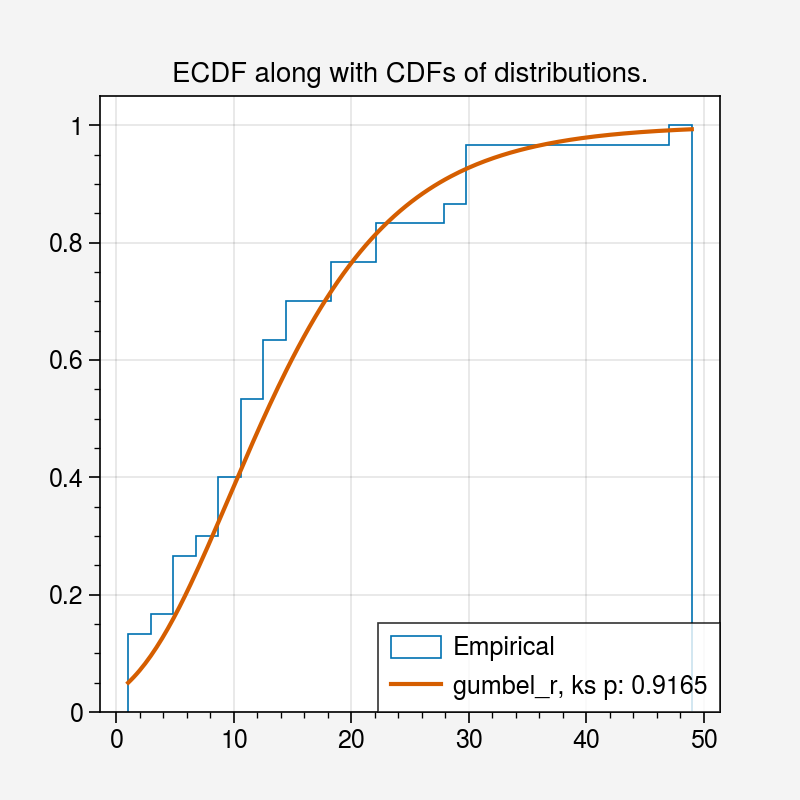

In [84]:
_ = attribution.validation.inspect_distributions(cube_data, dists)

Regression

In [85]:
gmst_data = attribution.utils.get_gmst(index_cube)

In [86]:
coefs, pvalues = attribution.utils.compute_cube_regression(
    index_cube, gmst_data, broadcast_coef=False
)

  0%|          | 0/44 [00:00<?, ?it/s]

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


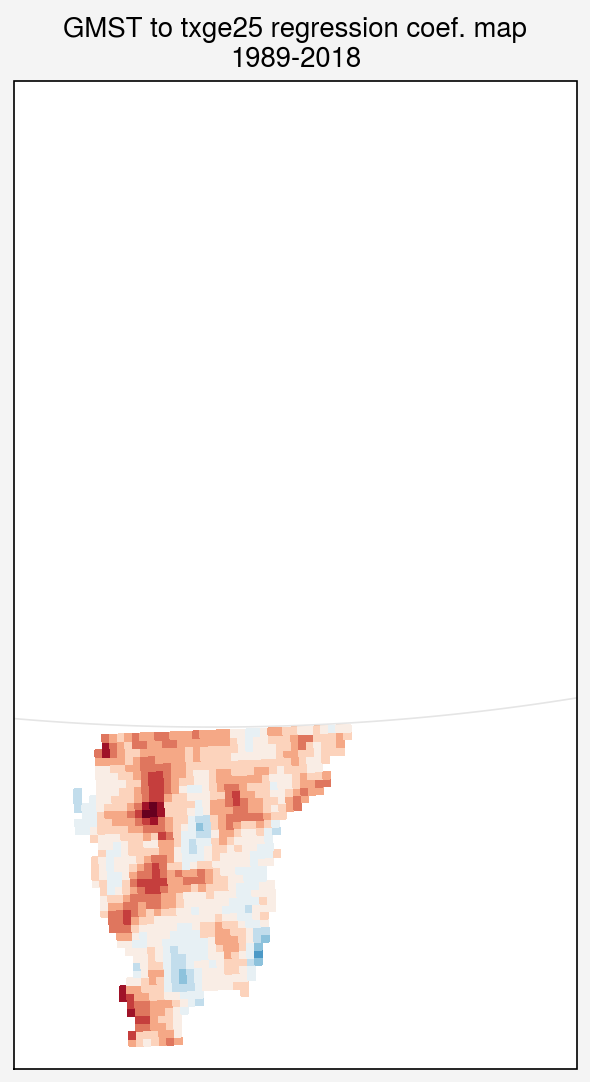

In [87]:
fig, ax = pplt.subplots(figwidth="7.5cm", projection=ccrs.epsg(3006))
attribution.plotting.plot_regression_map(
    index_cube, index_name, reg_coefs=coefs, pvalues=pvalues, p_lim=0.05, ax=ax[0]
)

### Probability ratio

#### Detrended CI

In [88]:
coefs_av, pvalues_av, _ = attribution.utils.compute_cube_regression(
    index_cube_av, gmst_data, broadcast_coef=False
)

In [89]:
# Since we want to shift every year to 2018 using the regression,
# we set 2018 to zero change.
gmst_diff = gmst_data[-1] - gmst_data
index_detrend = index_cube_av.data + coefs_av * gmst_diff.T

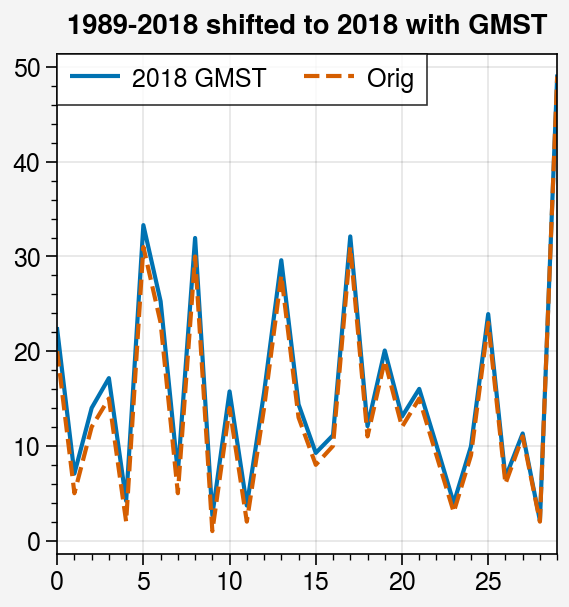

In [90]:
fig, ax = pplt.subplots()
ax.plot(index_detrend.compressed(), label="2018 GMST")
ax.plot(index_cube_av.data.compressed(), label="Orig", ls="--")
ax.legend()
ax.format(suptitle="1989-2018 shifted to 2018 with GMST")

In [91]:
index_cube_av_detrend = index_cube_av.copy()
index_cube_av_detrend.data = index_detrend.squeeze()

In [92]:
best_dist = attribution.validation.select_distribution(
    index_cube_av_detrend.data, dists
)
print(best_dist)
# Fit the distribution.
fit = best_dist.fit(index_cube_av_detrend.data)
# Get the quantile of the survival function.
threshold_quantile = best_dist.sf(threshold, *fit)

In [93]:
threshold_quantile

0.010545827335052143

In [94]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
# Note that we're not passing the detrended cube here. Cube is de-trended by the detredn kwarg.
prob_ratio_ci, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=1.0,
    detrend=True,
    dists=dists,
    client=client,
)

Submitting resampling tasks to client
Time to compute: 00:00:01


In [97]:
prob_ratio_ci

array([1.57857287, 1.67627918, 1.76373429, 1.87159762, 2.09875033])

In [98]:
np.save(
    os.path.join(
        CFG["paths"]["project_folder"], f"etc/{index_name}-ann_pbr_eobs_detrend"
    ),
    prob_ratio_ci,
)

#### Legacy

In [160]:
# Compute the bootstrapped CI of the probability ratio
prob_ratio_ci, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=0.05,
    dists=dists,
    client=client,
)

Submitting resampling tasks to client
Time to compute: 00:00:39


In [161]:
prob_ratio_ci

array([0.02573446, 1.        , 1.        , 1.        , 1.        ])

In [162]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
prob_ratio_ci_2, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=1.0,
    dists=dists,
    client=client,
)

Submitting resampling tasks to client
Time to compute: 00:00:40


In [163]:
prob_ratio_ci_2

array([ 0.02781484,  0.10288239,  0.47059496,  1.95058136, 21.07649152])

In [164]:
prob_ratio_ci = np.concatenate(
    [prob_ratio_ci_2[np.newaxis, ...], prob_ratio_ci[np.newaxis, ...]], axis=0
)

In [165]:
np.save(
    os.path.join(CFG["paths"]["project_folder"], f"etc/{index_name}-ann_pbr_eobs"),
    prob_ratio_ci,
)

## ERA5

In [99]:
file = glob.glob(CFG["paths"]["project_folder"] + f"/{variable}*era5*.nc")

In [100]:
era5_cube = iris.load_cube(file)

Summer data

In [101]:
mjja_cube = attribution.utils.select_season(era5_cube, "mjja", "summer")

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [102]:
mjja_cube_av = attribution.utils.compute_spatial_average(mjja_cube)

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/iris/analysis/cartography.py:412: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts a

Compute the index

In [103]:
index_cube = attribution.utils.compute_index(mjja_cube, index, client)

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

In [104]:
index_cube_av = attribution.utils.compute_index(mjja_cube_av, index, client)

Distribution check

In [105]:
cube_data = index_cube_av.data

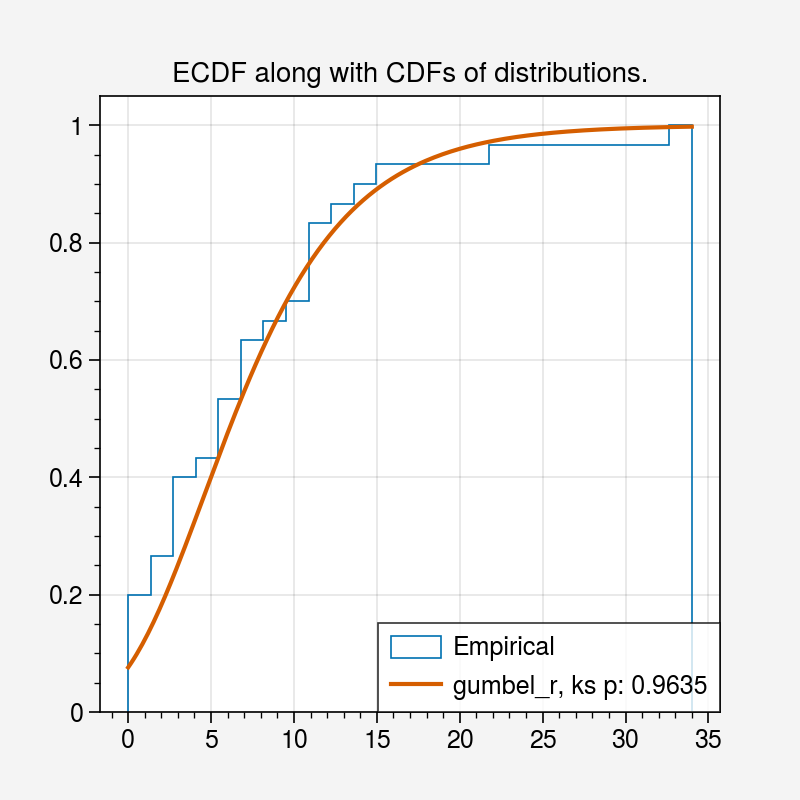

In [106]:
_ = attribution.validation.inspect_distributions(cube_data, dists)

Regression

In [107]:
gmst_data = attribution.utils.get_gmst(index_cube)

In [108]:
coefs, pvalues = attribution.utils.compute_cube_regression(
    index_cube, gmst_data, broadcast_coef=False
)

  0%|          | 0/44 [00:00<?, ?it/s]

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


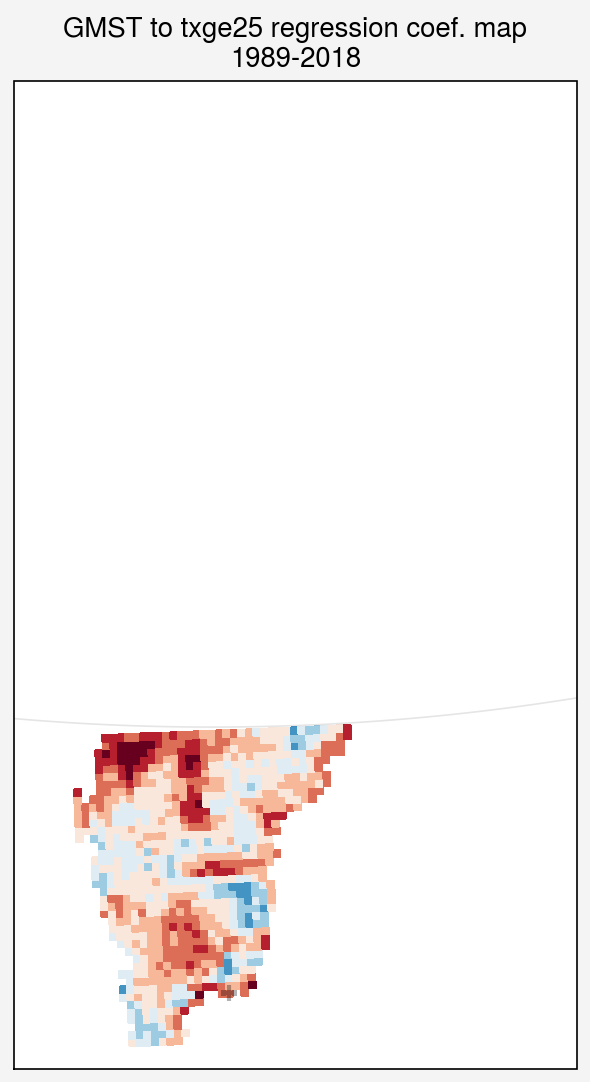

In [109]:
fig, ax = pplt.subplots(figwidth="7.5cm", projection=ccrs.epsg(3006))
attribution.plotting.plot_regression_map(
    index_cube, index_name, reg_coefs=coefs, pvalues=pvalues, p_lim=0.05, ax=ax[0]
)

### Probability ratio

Since the ERA5 dataset is a reanalysis product we can't assume that its absolute thresholds will represent observations.
To counteract this we will load the `threshold_quantile` we got from the GridClim dataset.

#### Detrended CI

In [110]:
coefs_av, _, _ = attribution.utils.compute_cube_regression(
    index_cube_av, gmst_data, broadcast_coef=False
)

In [111]:
# Since we want to shift every year to 2018 using the regression,
# we set 2018 to zero change.
gmst_diff = gmst_data[-1] - gmst_data
index_detrend = index_cube_av.data + coefs_av * gmst_diff.T

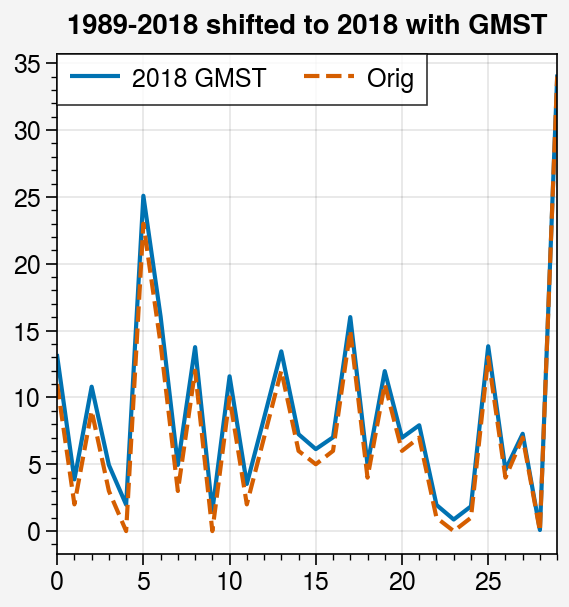

In [112]:
fig, ax = pplt.subplots()
ax.plot(index_detrend.compressed(), label="2018 GMST")
ax.plot(index_cube_av.data.compressed(), label="Orig", ls="--")
ax.format(suptitle="1989-2018 shifted to 2018 with GMST")
ax.legend();

In [113]:
index_cube_av_detrend = index_cube_av.copy()
index_cube_av_detrend.data = index_detrend.squeeze()

In [114]:
# Load in the threshold quantile from GridClim.
threshold_quantile = np.load(
    os.path.join(
        CFG["paths"]["project_folder"], f"etc/{index_name}_gc_threshold_q_detrend.npy"
    )
)

In [115]:
threshold_quantile

array(0.00861139)

In [116]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
# Note that we're not passing the detrended cube here. Cube is de-trended by the detredn kwarg.
prob_ratio_ci, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=1.0,
    detrend=True,
    dists=dists,
    client=client,
)

Submitting resampling tasks to client
Time to compute: 00:00:01


In [117]:
prob_ratio_ci

array([1.89923211, 2.09654038, 2.27777046, 2.5055831 , 2.92657912])

In [118]:
np.save(
    os.path.join(
        CFG["paths"]["project_folder"], f"etc/{index_name}-ann_pbr_era5_detrend"
    ),
    prob_ratio_ci,
)

#### Legacy

In [189]:
# Load in the threshold quantile
threshold_quantile = np.load(
    os.path.join(CFG["paths"]["project_folder"], f"etc/{index_name}_gc_threshold_q.npy")
)

In [190]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
prob_ratio_ci, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=0.05,
    dists=dists,
    client=client,
)

Submitting resampling tasks to client
Time to compute: 00:00:34


In [191]:
prob_ratio_ci

array([0.00906831, 1.        , 1.        , 1.        , 1.        ])

In [192]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
prob_ratio_ci_2, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=1.0,
    dists=dists,
    client=client,
)

Submitting resampling tasks to client
Time to compute: 00:00:35


In [193]:
prob_ratio_ci_2

array([9.63640293e-03, 5.07154275e-02, 3.10770282e-01, 1.03015852e+00,
       1.48857621e+01])

In [194]:
prob_ratio_ci = np.concatenate(
    [prob_ratio_ci_2[np.newaxis, ...], prob_ratio_ci[np.newaxis, ...]], axis=0
)

In [195]:
np.save(
    os.path.join(CFG["paths"]["project_folder"], f"etc/{index_name}-ann_pbr_era5"),
    prob_ratio_ci,
)

# Attribution: Models
Model data is treated essentially the same as the observational datasets.
The major difference is that the ensemble takes the place of the bootstrap, hence the uncertainty comes from the different ensemble members.

## CORDEX Ensemble

In [119]:
file = glob.glob(CFG["paths"]["project_folder"] + f"/{variable}*CORDEX-ENS*.nc")

In [120]:
cordex_cube = iris.load_cube(file)

Summer data

In [121]:
mjja_cube = attribution.utils.select_season(cordex_cube, "mjja", "summer")

In [122]:
import iris_utils.utils

weights = iris_utils.utils.get_weights(mjja_cube)

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/iris/analysis/cartography.py:412: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [123]:
mjja_cube_av = mjja_cube.collapsed(
    ["grid_latitude", "grid_longitude"], iris.analysis.MEAN, weights=weights
)

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/iris/coords.py:2216: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/iris/coords.py:2216: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.94s.  This is often caused by long-running GIL-holding f

Compute the index

In [124]:
index_cube = attribution.utils.compute_index(
    mjja_cube,
    index,
    client,
)

In [125]:
index_cube_av = attribution.utils.compute_index(
    mjja_cube_av,
    index,
    client,
)

INFO:distributed.core:Event loop was unresponsive in Nanny for 6.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 6.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 6.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 6.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 6.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Distribution check

In [126]:
# Some distributions describing extremes.
dists = {
    "genextreme": scstats.genextreme,
    "gamma": scstats.gamma,
    "genpareto": scstats.genpareto,
    "gengamma": scstats.gengamma,
    "gumbel_l": scstats.gumbel_l,
    "gumbel_r": scstats.gumbel_r,
}

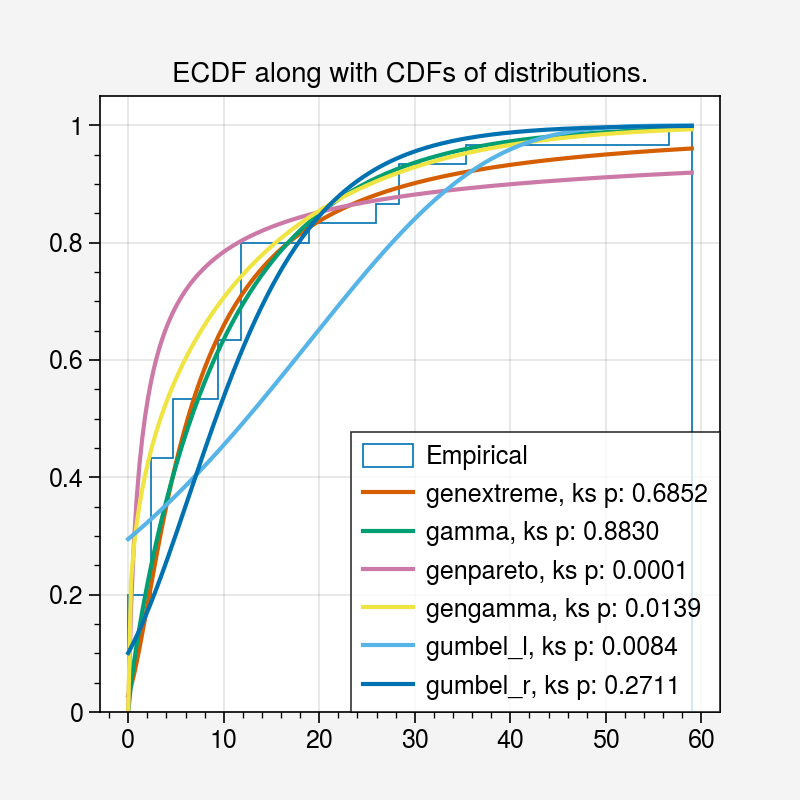

In [127]:
_ = attribution.validation.inspect_distributions(index_cube_av[60, :].data, dists)

### Probability ratio

For choosing a threshold for the model data we rely on the quantile from the observations.

#### Detrended CI

In [128]:
# Load in the threshold quantile
threshold_quantile = np.load(
    os.path.join(
        CFG["paths"]["project_folder"], f"etc/{index_name}_gc_threshold_q_detrend.npy"
    )
)

In [129]:
threshold_quantile

array(0.00861139)

In [130]:
gmst_data = attribution.utils.get_gmst(index_cube_av)

We want to take a look at the regression coefficients for the ensemble members and compare them to the regression coefficients, and its CI from the observations (GridClim).
Based on this we can then select the members where the regression is similar enough to observations.

In [131]:
reg_coefs, _ = attribution.utils.compute_cube_regression(
    index_cube_av.data, gmst_data, broadcast_coef=False
)

  0%|          | 0/66 [00:00<?, ?it/s]

In [132]:
# We create the ensemble member mask. The reg. coef. shoud lie within the CI of observed reg. coef.
mask = (reg_coefs >= coefs_ci[1, 0]) & (reg_coefs <= coefs_ci[1, 1])

In [133]:
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

We can then use the mask to select the members we want to use in the calculation of the probability ratio.

In [107]:
from importlib import reload

In [108]:
reload(attribution.bootstrap)

<module 'attribution.bootstrap' from '/home/sm_erhol/dev/attribution/attribution/bootstrap.py'>

In [134]:
# Some distributions describing extremes.
dists = {
    # "genextreme": scstats.genextreme,
    # "gamma": scstats.gamma,
    # "genpareto": scstats.genpareto,
    # "gengamma": scstats.gengamma,
    # "gumbel_l": scstats.gumbel_l,
    "gumbel_r": scstats.gumbel_r,
}

In [135]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
# Note that we're not passing the detrended cube here. Cube is de-trended by the detrend kwarg.
prob_ratio_ci, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av[mask],
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=1.0,
    detrend=True,
    ensemble=True,
    dists=dists,
    client=client,
)

Submitting resampling tasks to client
Time to compute: 00:00:00


In [136]:
prob_ratio_ci = np.concatenate([prob_ratio_ci, [mask.sum()]])

In [142]:
prob_ratio_ci

array([ 0.19746633,  1.2420605 ,  5.22501206, 12.33627956, 54.51151746,
       62.        ])

In [143]:
np.save(
    os.path.join(
        CFG["paths"]["project_folder"], f"etc/{index_name}-ann_pbr_cordex_detrend"
    ),
    prob_ratio_ci,
)

#### Legacy

In [22]:
# Load in the threshold quantile
threshold_quantile = np.load(
    os.path.join(CFG["paths"]["project_folder"], f"etc/{index_name}_gc_threshold_q.npy")
)

In [205]:
threshold_quantile

array(0.00756143)

In [206]:
prob_ratio_ci, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=0.05,
    dists=dists,
    ensemble=True,
    client=client,
)

(66, 30)
(30, 1)
Submitting resampling tasks to client
Time to compute: 00:00:03


In [198]:
prob_ratio_ci

array([ 1.        ,  1.        ,  1.        ,  1.        , 33.62871692])

In [ ]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
prob_ratio_ci_2, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=1.0,
    dists=dists,
    ensemble=True,
    client=client,
)

In [ ]:
prob_ratio_ci_2

In [ ]:
prob_ratio_ci = np.concatenate(
    [prob_ratio_ci_2[np.newaxis, ...], prob_ratio_ci[np.newaxis, ...]], axis=0
)

In [ ]:
np.save(
    os.path.join(CFG["paths"]["project_folder"], f"etc/{index_name}-ann_pbr_cordex"),
    prob_ratio_ci,
)

## S-Lens
Prob ratio for the S-Lens ensemble.

In [ ]:
file = glob.glob(CFG["paths"]["project_folder"] + f"/{variable}*s-lens*.nc")

In [ ]:
slens_cube = iris.load_cube(file)

Summer data

In [ ]:
mjja_cube = attribution.utils.select_season(slens_cube, "mjja", "summer")

In [ ]:
from iris_utils.utils import get_weights

In [ ]:
area_weights = get_weights(mjja_cube)
mjja_cube_av = mjja_cube.collapsed(
    ["longitude", "latitude"], iris.analysis.MEAN, weights=area_weights
)

Compute the index

In [ ]:
index_cube = attribution.utils.compute_index(
    mjja_cube,
    index,
    client,
)

In [ ]:
index_cube_av = attribution.utils.compute_index(
    mjja_cube_av,
    index,
    client,
)

Distribution check

In [ ]:
cube_data = index_cube_av.data

In [ ]:
_ = attribution.validation.inspect_distributions(cube_data[45, :], dists)

### Probability ratio

For choosing a threshold for the model data we rely on the quantile from the observations.

In [ ]:
# Load in the threshold quantile
threshold_quantile = np.load(
    os.path.join(CFG["paths"]["project_folder"], f"etc/{index_name}_gc_threshold_q.npy")
)

In [ ]:
threshold_quantile

In [ ]:
prob_ratio_ci, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=0.05,
    dists=dists,
    ensemble=True,
    client=client,
)

In [ ]:
prob_ratio_ci

In [ ]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
prob_ratio_ci_2, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av,
    threshold_quantile=threshold_quantile,
    delta_temp=-1.2,
    p_lim=1.0,
    dists=dists,
    ensemble=True,
    client=client,
)

In [ ]:
prob_ratio_ci_2

In [ ]:
prob_ratio_ci = np.concatenate(
    [prob_ratio_ci_2[np.newaxis, ...], prob_ratio_ci[np.newaxis, ...]], axis=0
)

In [ ]:
np.save(
    os.path.join(CFG["paths"]["project_folder"], f"etc/{index_name}-ann_pbr_s-lens"),
    prob_ratio_ci,
)

#### Detrended CI

In [ ]:
# Load in the threshold quantile
threshold_quantile = np.load(
    os.path.join(
        CFG["paths"]["project_folder"], f"etc/{index_name}_gc_threshold_q_detrend.npy"
    )
)

In [ ]:
threshold_quantile

In [ ]:
gmst_data = attribution.utils.get_gmst(index_cube_av)

Take a look at the regression coefficients for the ensemble members.

In [ ]:
reg_coefs, _ = attribution.utils.compute_cube_regression(
    index_cube_av.data, gmst_data, broadcast_coef=False
)

In [ ]:
reg_coefs

In [ ]:
# We create the ensemble member mask. The reg. coef. shoud lie within the CI of observed reg. coef.
mask = (reg_coefs >= coefs_ci[1, 0]) & (reg_coefs <= coefs_ci[1, 1])

In [ ]:
mask

In [ ]:
# Compute the bootstrapped CI of the probability ratio
# Note that this is much faster on an mp pool.
# Note that we're not passing the detrended cube here. Cube is de-trended by the detrend kwarg.
prob_ratio_ci, theta_hat_b = attribution.bootstrap.prob_ratio_ci(
    index_cube_av[mask],
    threshold_quantile=threshold_quantile,
    delta_temp=-1.0,
    p_lim=1.0,
    detrend=True,
    ensemble=True,
    dists=dists,
    client=client,
)

In [ ]:
prob_ratio_ci

In [ ]:
prob_ratio_ci = np.concatenate([prob_ratio_ci, [mask.sum()]])

In [ ]:
np.save(
    os.path.join(
        CFG["paths"]["project_folder"], f"etc/{index_name}-ann_pbr_s-lens_detrend"
    ),
    prob_ratio_ci,
)

Before continuing to the next notebook it is good to shutdown the dask client.

In [ ]:
client.shutdown()

## Next steps

[Daily scaling attribution](./5_attribution_ds.ipynb)

[Synthesis](./6_synthesis.ipynb)